# AI and Finance Project
## Objective and team composition


Tommaso Menti VR504908 \
Simone Murari VR502597 \
Masud Talukdar VR510632

The goal of our project is to develop a reinforcement learning agent that is able to open long and short positions in order to maximize the profit on the IVV S&P500 ETF. \
The main idea about this is that our agent can find some common 'patterns' in the stocks market trends and determine the optimal timing for specific actions.
We want to optimize the percentage of successful positions.
It is considered a successful position a position where a profit is made.
In order to evaluate this we look at the success rate: \
Success rate = Positive positions / Total number of positions


In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import warnings

# Set random seed for reproducibility
seed = 21
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data import, analysis and preparation


(978037, 6)


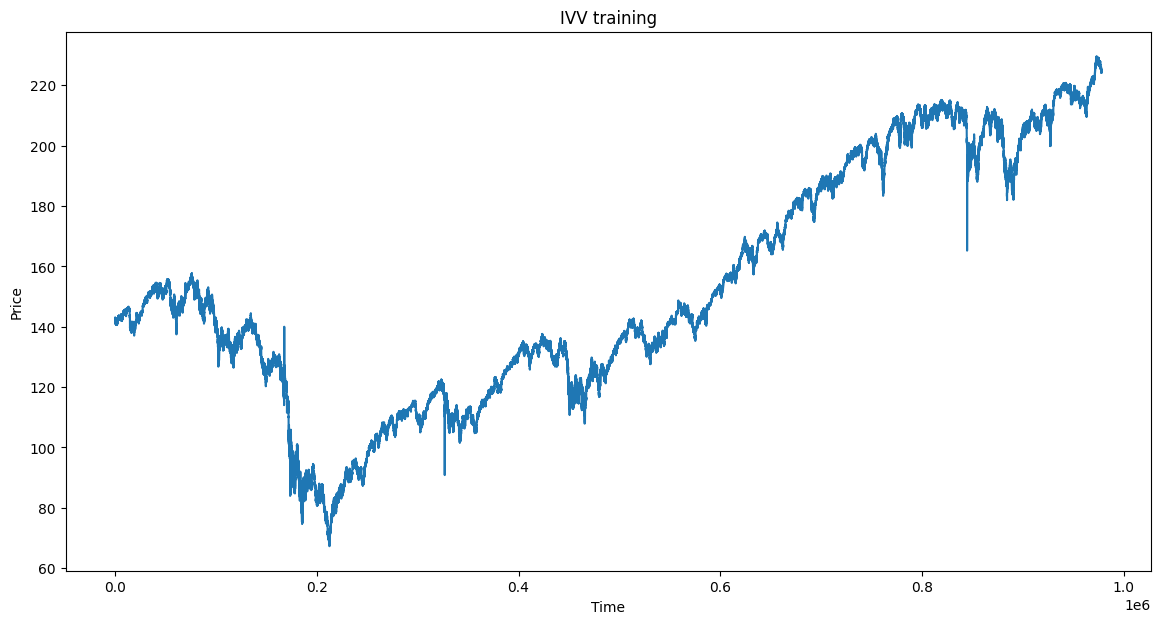

In [2]:
df_train = pd.read_csv('data/IVV_1m_training.csv')
print(df_train.shape)
plt.figure(figsize=(14, 7))
plt.plot(df_train['Close'])
plt.title('IVV training')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [3]:
df_train = df_train.sort_values('DateTime')
df_train = df_train.reset_index(drop=True)
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'])

# Add the prediction column obtained using the LSTM model to the training data
df_train_pred = pd.read_csv('lstm/train_next_close_prediction.csv')

df_train

,DateTime,Low,Volume,Open,High,Close
0,2007-01-03 14:30:00+00:00,142.10,133200,142.530,142.530,142.260
1,2007-01-03 14:31:00+00:00,142.28,4400,142.280,142.450,142.450
2,2007-01-03 14:32:00+00:00,142.41,3500,142.420,142.470,142.470
3,2007-01-03 14:33:00+00:00,142.52,300,142.540,142.540,142.538
4,2007-01-03 14:34:00+00:00,142.46,3400,142.519,142.519,142.460
...,...,...,...,...,...,...
978032,2016-12-30 20:55:00+00:00,224.25,73404,224.280,224.450,224.450
978033,2016-12-30 20:56:00+00:00,224.37,55152,224.440,224.490,224.450
978034,2016-12-30 20:57:00+00:00,224.45,104419,224.450,224.710,224.670
978035,2016-12-30 20:58:00+00:00,224.63,248625,224.670,224.800,224.760


In [4]:
# Remove the first rows from the training data as the prediction is not available for these rows and add the prediction column to the training data
df_train = df_train.iloc[df_train.shape[0] - df_train_pred.shape[0]:]
df_train['Prediction'] = df_train_pred.iloc[:, 0].values
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)
df_train['Low'] = df_train['Low'].astype(np.float32)
df_train['Volume'] = df_train['Volume'].astype(np.float32)
df_train['Open'] = df_train['Open'].astype(np.float32)
df_train['High'] = df_train['High'].astype(np.float32)
df_train['Close'] = df_train['Close'].astype(np.float32)
df_train['Prediction'] = df_train['Prediction'].astype(np.float32)
df_train

,DateTime,Low,Volume,Open,High,Close,Prediction
0,2007-01-03 15:31:00+00:00,143.039993,7500.0,143.039993,143.070007,143.039993,143.119995
1,2007-01-03 15:32:00+00:00,143.029999,1000.0,143.070007,143.070007,143.039993,143.100006
2,2007-01-03 15:33:00+00:00,142.979996,500.0,143.009995,143.009995,142.979996,143.139999
3,2007-01-03 15:34:00+00:00,142.992004,500.0,142.992004,143.009995,143.007996,143.149994
4,2007-01-03 15:35:00+00:00,143.009995,2200.0,143.009995,143.029999,143.009995,143.100006
...,...,...,...,...,...,...,...
977971,2016-12-30 20:55:00+00:00,224.250000,73404.0,224.279999,224.449997,224.449997,224.470001
977972,2016-12-30 20:56:00+00:00,224.369995,55152.0,224.440002,224.490005,224.449997,224.490005
977973,2016-12-30 20:57:00+00:00,224.449997,104419.0,224.449997,224.710007,224.669998,224.630005
977974,2016-12-30 20:58:00+00:00,224.630005,248625.0,224.669998,224.800003,224.759995,224.630005


(292620, 6)


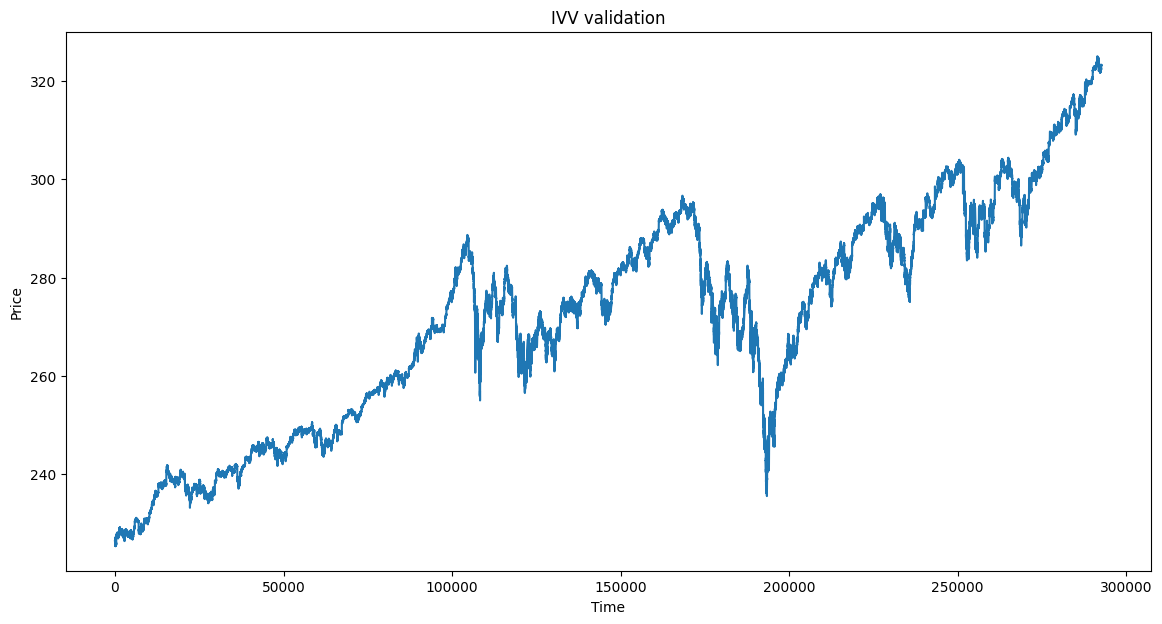

In [5]:
# Now we do the same for the validation data
df_val = pd.read_csv('data/IVV_1m_validation.csv')
print(df_val.shape)
plt.figure(figsize=(14, 7))
plt.plot(df_val['Close'])
plt.title('IVV validation')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [6]:
df_val = df_val.sort_values('DateTime')
df_val = df_val.reset_index(drop=True)
df_val['DateTime'] = pd.to_datetime(df_val['DateTime'])

df_val_pred = pd.read_csv('lstm/val_next_close_prediction.csv')

df_val

,DateTime,Low,Volume,Open,High,Close
0,2017-01-03 14:30:00+00:00,226.3100,238433,226.4000,226.490,226.3200
1,2017-01-03 14:31:00+00:00,226.1900,20058,226.3200,226.390,226.2100
2,2017-01-03 14:32:00+00:00,226.2200,15368,226.2200,226.270,226.2499
3,2017-01-03 14:33:00+00:00,226.2210,12309,226.2499,226.367,226.3600
4,2017-01-03 14:34:00+00:00,226.3654,18264,226.3654,226.510,226.4600
...,...,...,...,...,...,...
292615,2019-12-31 20:55:00+00:00,323.2199,19425,323.2200,323.350,323.3400
292616,2019-12-31 20:56:00+00:00,323.1900,23830,323.3300,323.350,323.1900
292617,2019-12-31 20:57:00+00:00,323.0700,57869,323.1700,323.200,323.1000
292618,2019-12-31 20:58:00+00:00,323.0400,78933,323.1250,323.160,323.1000


In [7]:
df_val = df_val.iloc[df_val.shape[0] - df_val_pred.shape[0]:]
df_val['Prediction'] = df_val_pred.iloc[:, 0].values
df_val = df_val.dropna()
df_val = df_val.reset_index(drop=True)
df_val['Low'] = df_val['Low'].astype(np.float32)
df_val['Volume'] = df_val['Volume'].astype(np.float32)
df_val['Open'] = df_val['Open'].astype(np.float32)
df_val['High'] = df_val['High'].astype(np.float32)
df_val['Close'] = df_val['Close'].astype(np.float32)
df_val['Prediction'] = df_val['Prediction'].astype(np.float32)
df_val

,DateTime,Low,Volume,Open,High,Close,Prediction
0,2017-01-03 15:31:00+00:00,226.919998,6879.0,227.000000,227.000000,226.919998,227.100006
1,2017-01-03 15:32:00+00:00,226.850006,71755.0,226.899994,226.910004,226.850006,227.190002
2,2017-01-03 15:33:00+00:00,226.820007,3715.0,226.839996,226.869995,226.820007,227.130005
3,2017-01-03 15:34:00+00:00,226.789993,7357.0,226.809998,226.822998,226.799393,227.080002
4,2017-01-03 15:35:00+00:00,226.706299,32904.0,226.810104,226.820007,226.729996,227.059998
...,...,...,...,...,...,...,...
292554,2019-12-31 20:55:00+00:00,323.219910,19425.0,323.220001,323.350006,323.339996,319.950012
292555,2019-12-31 20:56:00+00:00,323.190002,23830.0,323.329987,323.350006,323.190002,320.089996
292556,2019-12-31 20:57:00+00:00,323.070007,57869.0,323.170013,323.200012,323.100006,320.140015
292557,2019-12-31 20:58:00+00:00,323.040009,78933.0,323.125000,323.160004,323.100006,320.079987


## Method and assumptions

Our agent has 2 different strategies: 
- Exploit long positions: at first it buys some shares and later it sells them. The goal is to sell at a higher price than the purchase price of the stock.
- Exploit short positions: at first it borrows some shares and later it buys them back. The goal is to buy back at a lower price than the one when it borrowed the shares.

In order to do so the agent considers the data from the OHLCV values of the last 5 minutes, for example the agent decides the amount of shares it wants to trade based on the Volume of the ETF being traded.
The agent gets a positive reward if the balance increases and a negative reward if it wasn't a useful action. 
We want our agent to perform between 2 and 8 trades per day, so it gets a negative reward if the number of trades does not respect these conditions.
Lastly we want to avoid any trade being open overnight, so the agent is penalized if some trades are forcibly closed at the end of the trading day.


Our trading agent starts with a balance of 10000.\
The window size defines the amount of minutes the agent looks back in order to get its state, we set this parameter to 5. \
We also set a trading fee equal to 0.001, this fee is applied to every transaction executed by the agent. \
The agent can open only one position at a time, e.g.: he can open a long position and "expand" it by buying other shares on top of it but he can not open a short position at the same time, it must close the long one first. \
Lastly, we do not consider market liquidity and market impact: whenever the agent wants to perform an action it is immediately executed and the actions of the agent have no effect on the market.


## Training and validation

In [11]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
INITIAL_ACCOUNT_BALANCE = 10000


class StockTradingEnv():
    """A stock trading environment"""

    def __init__(self, df):
        self.df = df
        self.datetime = df['DateTime']
        self.current_step = 5
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.balance_at_start_of_position = 0
        self.shares_held = 0
        self.trading_fee = 0.001
        self.day = 1
        self.num_trades = 0
        self.num_positions = 0
        self.successful_positions = 0
        self.history = {
            'buy': [],
            'sell': []
        }
        self.action_space = 3
        self.observation_space = self.get_state().shape
        
    def get_state(self):
        # Get the data points for the last 5 minutes and scale to between 0-1
        frame = np.array([
            self.df.loc[self.current_step - 4: self.current_step, 'Open'].values / self.df['Open'].max(),
            self.df.loc[self.current_step - 4: self.current_step, 'High'].values / self.df['High'].max(),
            self.df.loc[self.current_step - 4: self.current_step, 'Low'].values / self.df['Low'].max(),
            self.df.loc[self.current_step - 4: self.current_step, 'Close'].values / self.df['Close'].max(),
            self.df.loc[self.current_step - 4: self.current_step, 'Volume'].values / self.df['Volume'].max()
        ])

        # Append additional data and scale each value to between 0-1
        other = np.array([
            self.balance / MAX_ACCOUNT_BALANCE,
            self.net_worth / MAX_ACCOUNT_BALANCE,
            self.shares_held / MAX_NUM_SHARES,
            self.successful_positions / self.num_positions if self.num_positions > 0 else 0,
            self.df.loc[self.current_step, 'Prediction'] / self.df['Prediction'].max()
        ])

        obs = np.append(frame, [other], axis=0)
        obs = obs.reshape(1, -1)
        obs = obs.astype(np.float32)
        return obs

    def _take_action(self, action):

        reward = 0
        profit = 0
        current_price = self.df.loc[self.current_step, 'Close']

        # Set the amount to be bought/sold based on the volume of the last 5 minutes
        amount = np.mean(self.df.loc[self.current_step - 4: self.current_step, 'Volume'].values / self.df['Volume'].max())
        amount = min(np.round(amount * 50, 2), 1)

        if self.net_worth > INITIAL_ACCOUNT_BALANCE and amount >= 0.5:
            amount = 0.25

        if self.num_trades / self.day >= 8:
            action = 0
            reward = 0

        if self.shares_held == 0 and action == 1 or action == 2:
            reward = 10
        elif self.shares_held > 0 and action == 2:
            reward = 10
        elif self.shares_held < 0 and action == 1:
            reward = 10

        if self.current_step + 1 != len(self.df):
            if self.datetime[self.current_step + 1].day != self.datetime[self.current_step].day:
                # If the next day is a new day, sell/buy all shares
                if self.shares_held != 0:
                    if self.shares_held > 0:
                        if action != 2:
                            reward = -5
                        action = 2
                        amount = 1
                    else:
                        if action != 1:
                            reward = -5
                        action = 1
                        amount = 1     
                else:
                    action = 0
                    reward = 0
        else:
            if self.shares_held != 0:
                if self.shares_held > 0:
                    if action != 2:
                        reward = -5
                    action = 2
                    amount = 1
                else:
                    if action != 1:
                        reward = -5
                    action = 1
                    amount = 1
            else:
                action = 0
                reward = 0

        if action == 1:
            # Buy amount % of balance in shares
            self.history['sell'].append(None)
            if self.shares_held >= 0:
                total_possible = self.balance / (current_price * (1 + self.trading_fee))
                shares_bought = int(total_possible * amount)
                if shares_bought > 0:
                    cost = shares_bought * current_price * (1 + self.trading_fee)
                    if self.shares_held == 0:
                        self.balance_at_start_of_position = self.balance
                    self.balance -= cost
                    self.shares_held += shares_bought
                    self.num_trades += 1
                    self.history['buy'].append(current_price)
                else:
                    self.history['buy'].append(None)
            else:
                # Cover short
                shares_bought = int(-self.shares_held * amount)
                if shares_bought > 0:
                    cost = shares_bought * current_price * (1 + self.trading_fee)
                    self.balance -= cost
                    self.shares_held += shares_bought
                    self.num_trades += 1
                    self.history['buy'].append(current_price)
                    if self.shares_held == 0:
                        self.num_positions += 1
                        profit = self.balance - self.balance_at_start_of_position
                        if profit > 0:
                            self.successful_positions += 1
                else:
                    self.history['buy'].append(None)
        elif action == 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.history['buy'].append(None)
            if shares_sold > 0:
                self.balance += shares_sold * current_price * (1 - self.trading_fee)
                self.shares_held -= shares_sold
                self.num_trades += 1
                self.history['sell'].append(current_price)
                if self.shares_held == 0:
                    self.num_positions += 1
                    profit = self.balance - self.balance_at_start_of_position
                    if profit > 0:
                        self.successful_positions += 1
            elif self.shares_held <= 0:
                # Start short
                total_possible = self.balance / (current_price * (1 + self.trading_fee))
                shares_borrowed = int(total_possible * amount)
                if shares_borrowed > 0:
                    if self.shares_held == 0:
                        self.balance_at_start_of_position = self.balance
                    self.shares_held -= shares_borrowed
                    self.balance += shares_borrowed * current_price * (1 - self.trading_fee)
                    self.num_trades += 1
                    self.history['sell'].append(current_price)
                    reward -= 2 # Shorting is risky
                else:
                    self.history['sell'].append(None)
            else:
                self.history['sell'].append(None)
        elif action == 0:
            self.history['sell'].append(None)
            self.history['buy'].append(None)

        self.net_worth = self.balance + self.shares_held * current_price

        if action == 0 and self.num_trades == 0:
            reward -= 5
        elif action == 0 and round(self.num_trades / self.day, 2) < 2:
            reward -= 5
        elif self.shares_held == 0 and action != 0:
            if profit == 0:
                reward += 5
            if profit > 0 and self.balance - INITIAL_ACCOUNT_BALANCE < 0:
                reward += profit
            elif self.balance - INITIAL_ACCOUNT_BALANCE > 0:
                reward += 5

        reward += (self.successful_positions / self.num_positions) * 10 if self.num_positions > 0 else 0

        return reward
    
    def step(self, action):

        reward = self._take_action(action)

        self.current_step += 1

        if self.current_step < len(self.df):
            if self.datetime[self.current_step].day != self.datetime[self.current_step - 1].day:
                self.day += 1


        if self.net_worth <= 0:
            done = True
            reward -= 1000
        elif self.current_step >= self.df.shape[0]:
            done = True
        else:
            done = False

        if not done:
            obs = self.get_state()
        else:
            obs = None

        return obs, reward, done

    def reset(self, step=5):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.balance_at_start_of_position = 0
        self.shares_held = 0
        self.num_trades = 0
        self.num_positions = 0
        self.successful_positions = 0
        self.current_step = step
        self.history = {
            'buy': [],
            'sell': []
        }
        self.day = 1
        return self.get_state()

In [12]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:
class DQN(nn.Module):
	def __init__(self, state_size, action_size):
		super(DQN, self).__init__()
		self.main = nn.Sequential(
			nn.Linear(state_size, 64),
			nn.LeakyReLU(0.01, inplace=True),
			nn.Linear(64, 32),
			nn.LeakyReLU(0.01, inplace=True),
			nn.Linear(32, 8),
			nn.LeakyReLU(0.01, inplace=True),
			nn.Linear(8, action_size),
		)
	
	def forward(self, input):
		return self.main(input)

In [11]:
def training_loop(env, neural_net, updateRule, eps=1.0, episodes=100, eps_decay=0.99995, eps_min=0.01):

	# Initialize the optimizer 
	optimizer = optim.SGD(neural_net.parameters(), lr=0.05)
	rewards_list, memory_buffer = [], ReplayMemory(10000)
	averaged_rewards = []
	episodes_stats = []
	end_of_episode_step = 5
	
	starts = np.arange(0, len(df_train) - 225000, 225000)
	starts = [val for val in starts for _ in (0, 1)]
	starts.append(starts[-1])
	starts.append(starts[-1])
	
	for ep in tqdm(range(episodes), desc='Episodes'):
		action_count = [0, 0, 0]

		# Sample a subset of the training data
		start = starts[ep % len(starts)]
		if start != starts[-1]:
			sample_df = df_train.iloc[start:start + 225000]
		else:
			sample_df = df_train.iloc[start:]
		sample_df = sample_df.reset_index(drop=True)
		env.df = sample_df
		logs = [env.current_step, int(env.df.shape[0] * 0.25), int(env.df.shape[0] * 0.5), int(env.df.shape[0] * 0.75), int(env.df.shape[0]) - 1]

		state = env.reset(end_of_episode_step)
		state = torch.tensor(state, device=device, dtype=torch.float32)
		ep_reward = 0
		logs = [0, int(env.df.shape[0] * 0.25), int(env.df.shape[0] * 0.5), int(env.df.shape[0] * 0.75), env.df.shape[0] - 1]
		for i in tqdm(range(env.df.shape[0]), desc='Steps', leave=False):
			if np.random.rand() < eps:
				action = np.random.choice([0, 1, 2]).astype(np.int64)
			else:
				with torch.no_grad():
					action = torch.argmax(neural_net(state)).item()
					action_count[action] += 1
			eps = max(eps * eps_decay, eps_min)

			next_state, reward, done = env.step(action)
			if int(env.balance) <= int(env.df.Close.min()) and env.shares_held == 0:
				done = True
				next_state = None
				reward -= 1000

			if next_state is not None:
				next_state = torch.tensor(next_state, device=device, dtype=torch.float32)
			memory_buffer.push(state, action, next_state, reward, torch.tensor([done], device=device))
			ep_reward += reward

			if i in logs or done:
				profit = env.net_worth - INITIAL_ACCOUNT_BALANCE

				if done:
					print('----DONE----')
				if done and env.net_worth <= 0:
					print('----BANKRUPT----')
				print(f'Day: {env.day}')
				print(f'Current step: {env.current_step}')
				print(f'Episodes reward: {ep_reward}')
				print(f'Profit: {profit}')
				print(f'Net Worth: {env.net_worth}')
				print(f'Balance: {env.balance}')
				print(f'Shares held: {env.shares_held}')
				print(f'Trades: {env.num_trades}')
				print(f'Trades per day: {env.num_trades / env.day}')
				print(f'Action: {action}, reward: {reward}')
				print(f'Epsilon: {eps}')
				print(f'Num positions: {env.num_positions}')
				print(f'Successful positions: {env.successful_positions}')
				print(f'Actions: {action_count}')
				print(f'Min close: {env.df.Close.min()}')
				print('\n')

			# Perform the actual training
			updateRule(neural_net, memory_buffer, optimizer)
				
			if done:
				if env.current_step < len(env.df) - 1:
					print(env.current_step, len(env.df) - 1)
					end_of_episode_step = env.current_step
				else:
					end_of_episode_step = 5
				break

			# Update the current state
			state = next_state

		# Update the reward list to return
		rewards_list.append(ep_reward)
		averaged_rewards.append(np.mean(rewards_list))
		print( f"episode {ep+1:2d}: mean reward: {averaged_rewards[-1]:3.2f}, epsilon: {eps}" )
		episodes_stats.append([ep, ep_reward, env.net_worth, env.balance, env.shares_held, env.num_trades, env.num_trades / env.day, profit, env.history['buy'], env.history['sell']])

	return averaged_rewards, episodes_stats

In [12]:
def DQNupdate(neural_net, memory, optimizer, batch_size=32, gamma=0.99):

	if len(memory) < 1000:
		return
	
	# Sample a random batch of transitions
	transitions = memory.sample(batch_size)
	batch = Transition(*zip(*transitions))
	
	done_batch = torch.cat(batch.done).to(device)
	non_final_mask = ~done_batch
	non_final_next_states = torch.cat([s for s, d in zip(batch.next_state, batch.done) if not d])
	state_batch = torch.cat(batch.state).to(device)
	action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)
	reward_batch = torch.tensor(batch.reward, device=device)

	# Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
	state_action_values = neural_net(state_batch).gather(1, action_batch)

	# Compute V(s_{t+1}) for all next states.
	next_state_values = torch.zeros(batch_size, device=device)
	next_state_values[non_final_mask] = neural_net(non_final_next_states).max(1)[0].detach()

	# Compute the expected Q values
	expected_state_action_values = (next_state_values * gamma) + reward_batch

	# Compute Huber loss
	loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1)).to(device)

	# Optimize the model
	optimizer.zero_grad()
	loss.backward()
	for param in neural_net.parameters():
		param.grad.data.clamp_(-1, 1)
	optimizer.step()

In [13]:
train_env = StockTradingEnv(df_train)
action_space = train_env.action_space
state_space = train_env.observation_space[1]
neural_net = DQN(state_space, action_space).to(device)
neural_net.train()
episodes = 10
eps = 1
eps_min = 0.01
eps_decay = (eps_min / eps) ** (1 / (train_env.df.shape[0] * (1.5)))
averaged_rewards_training, episodes_stats_training = training_loop(train_env, neural_net, DQNupdate, eps=eps, episodes=episodes, eps_decay=eps_decay, eps_min=eps_min)

torch.save(neural_net.state_dict(), 'DQN_trained_model.pth')

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: -5
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 0, reward: -5
Epsilon: 0.9999968607525763
Num positions: 0
Successful positions: 0
Actions: [0, 0, 0]
Min close: 67.25


Day: 145
Current step: 56256
Episodes reward: 192977.7387439184
Profit: -794.1342577056312
Net Worth: 9205.865742294369
Balance: 3901.6258741303072
Shares held: 36
Trades: 1160
Trades per day: 8.0
Action: 0, reward: 3.680555555555556
Epsilon: 0.8381266267544504
Num positions: 144
Successful positions: 53
Actions: [1123, 1618, 2006]
Min close: 67.25


Day: 291
Current step: 112506
Episodes reward: 403693.28244734067
Profit: -2042.5277983702
Net Worth: 7957.4722016298
Balance: 10710.872165008706
Shares held: -20
Trades: 2328
Trades per day: 8.0
Action: 2, reward: 3.6518771331058018
Epsilon: 0.702458447665671
Num positions: 293
Successful positions: 107
Actions: [5118, 6197, 6374]
Min close: 67.25


Day: 435
Current step: 168756
E

Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: 10
Profit: -0.14305000305103022
Net Worth: 9999.856949996949
Balance: 9856.806946945191
Shares held: 1
Trades: 1
Trades per day: 1.0
Action: 1, reward: 10
Epsilon: 0.4934571651287328
Num positions: 0
Successful positions: 0
Actions: [0, 0, 0]
Min close: 67.25


Day: 145
Current step: 56256
Episodes reward: 145233.12145378007
Profit: -2269.122443435619
Net Worth: 7730.877556564381
Balance: 14066.497399093678
Shares held: -43
Trades: 1160
Trades per day: 8.0
Action: 1, reward: 2.1527777777777777
Epsilon: 0.41358088758989325
Num positions: 144
Successful positions: 31
Actions: [11182, 8887, 10744]
Min close: 67.25


Day: 291
Current step: 112506
Episodes reward: 304238.9024674908
Profit: -4688.842849586363
Net Worth: 5311.157150413637
Balance: 8339.897110130434
Shares held: -22
Trades: 2328
Trades per day: 8.0
Action: 2, reward: 3.071672354948806
Epsilon: 0.3466342423764831
Num positions: 293
Successful positions: 90
Actions: [24748, 20319, 20565]
M

Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: -5
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 0, reward: -5
Epsilon: 0.24350073822594653
Num positions: 0
Successful positions: 0
Actions: [1, 0, 0]
Min close: 83.87000274658203


Day: 145
Current step: 56256
Episodes reward: 272022.79437268944
Profit: -639.3306867141091
Net Worth: 9360.66931328589
Balance: 14049.129197929446
Shares held: -42
Trades: 1160
Trades per day: 8.0
Action: 2, reward: 4.375
Epsilon: 0.20408509301513456
Num positions: 144
Successful positions: 63
Actions: [18056, 13608, 12140]
Min close: 83.87000274658203


Day: 291
Current step: 112506
Episodes reward: 528182.5078842322
Profit: -746.1283197172488
Net Worth: 9253.871680282751
Balance: 3638.3718023530632
Shares held: 50
Trades: 2328
Trades per day: 8.0
Action: 0, reward: 4.137931034482759
Epsilon: 0.17104968754693475
Num positions: 290
Successful positions: 120
Actions: [36134, 26355, 27014]
Min close: 83.870002746582

Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: -5
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 0, reward: -5
Epsilon: 0.1201575611960405
Num positions: 0
Successful positions: 0
Actions: [1, 0, 0]
Min close: 83.87000274658203


Day: 145
Current step: 56256
Episodes reward: 284874.27199171955
Profit: -2741.5187196883116
Net Worth: 7258.481280311688
Balance: 4690.991343483075
Shares held: 23
Trades: 1160
Trades per day: 8.0
Action: 1, reward: 4.652777777777778
Epsilon: 0.10070756759025022
Num positions: 144
Successful positions: 67
Actions: [23567, 14887, 11554]
Min close: 83.87000274658203


Day: 291
Current step: 112506
Episodes reward: 546797.637346265
Profit: -3569.446234649501
Net Worth: 6430.553765350499
Balance: 4858.213799530186
Shares held: 14
Trades: 2328
Trades per day: 8.0
Action: 0, reward: 4.310344827586206
Epsilon: 0.08440595888425026
Num positions: 290
Successful positions: 125
Actions: [44928, 33494, 22723]
Min close: 83.870

Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: -5
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 0, reward: -5
Epsilon: 0.05929279565133378
Num positions: 0
Successful positions: 0
Actions: [1, 0, 0]
Min close: 107.87000274658203


Day: 145
Current step: 56256
Episodes reward: 270239.3711741731
Profit: -3298.7594351500693
Net Worth: 6701.240564849931
Balance: 4640.09050991829
Shares held: 15
Trades: 1160
Trades per day: 8.0
Action: 0, reward: 3.918918918918919
Epsilon: 0.04969502681507925
Num positions: 148
Successful positions: 58
Actions: [22839, 15204, 15176]
Min close: 107.87000274658203


Day: 291
Current step: 112506
Episodes reward: 509288.31420221005
Profit: -5170.998412109225
Net Worth: 4829.001587890775
Balance: 5842.583344482572
Shares held: -7
Trades: 2328
Trades per day: 8.0
Action: 0, reward: 3.91156462585034
Epsilon: 0.04165085594333769
Num positions: 294
Successful positions: 115
Actions: [45979, 29119, 31782]
Min close: 107.

Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: 8
Profit: -1.7433000183100376
Net Worth: 9998.25669998169
Balance: 11741.556718292237
Shares held: -15
Trades: 1
Trades per day: 1.0
Action: 2, reward: 8
Epsilon: 0.02925854670448445
Num positions: 0
Successful positions: 0
Actions: [0, 0, 1]
Min close: 107.87000274658203


Day: 145
Current step: 56256
Episodes reward: 289243.0688152398
Profit: 1764.108965988291
Net Worth: 11764.108965988291
Balance: 15474.179064865244
Shares held: -27
Trades: 1160
Trades per day: 8.0
Action: 2, reward: 4.513888888888889
Epsilon: 0.024522444035186882
Num positions: 144
Successful positions: 65
Actions: [23336, 20415, 10980]
Min close: 107.87000274658203


Day: 291
Current step: 112506
Episodes reward: 534117.3161622094
Profit: -343.8177248685279
Net Worth: 9656.182275131472
Balance: 8642.600518539675
Shares held: 7
Trades: 2328
Trades per day: 8.0
Action: 1, reward: 4.068965517241379
Epsilon: 0.02055297781986898
Num positions: 290
Successful positions: 118
Action

Steps:   0%|          | 0/302976 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: -5
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 0, reward: -5
Epsilon: 0.014437884836674967
Num positions: 0
Successful positions: 0
Actions: [1, 0, 0]
Min close: 165.22000122070312


Day: 195
Current step: 75750
Episodes reward: 290570.85699272336
Profit: -1023.5748901061743
Net Worth: 8976.425109893826
Balance: 10393.365097076443
Shares held: -7
Trades: 1560
Trades per day: 8.0
Action: 0, reward: 3.3505154639175254
Epsilon: 0.011382488901731266
Num positions: 194
Successful positions: 65
Actions: [29910, 21819, 23026]
Min close: 165.22000122070312


Day: 391
Current step: 151494
Episodes reward: 610968.2643667775
Profit: -2613.502738006513
Net Worth: 7386.497261993487
Balance: 4418.917244903643
Shares held: 14
Trades: 3128
Trades per day: 8.0
Action: 2, reward: 3.4102564102564106
Epsilon: 0.01
Num positions: 390
Successful positions: 133
Actions: [60461, 43412, 45868]
Min close: 165.22000122

Steps:   0%|          | 0/302976 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: -5
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 0, reward: -5
Epsilon: 0.01
Num positions: 0
Successful positions: 0
Actions: [1, 0, 0]
Min close: 165.22000122070312


Day: 195
Current step: 75750
Episodes reward: 333628.3911607705
Profit: -694.0111220245308
Net Worth: 9305.98887797547
Balance: 7889.048890792852
Shares held: 7
Trades: 1560
Trades per day: 8.0
Action: 2, reward: 4.081632653061225
Epsilon: 0.01
Num positions: 196
Successful positions: 80
Actions: [22666, 36273, 16060]
Min close: 165.22000122070312


Day: 391
Current step: 151494
Episodes reward: 704389.6043848229
Profit: -1091.6863891906141
Net Worth: 8908.313610809386
Balance: 7212.553601043761
Shares held: 8
Trades: 3128
Trades per day: 8.0
Action: 2, reward: 4.260204081632653
Epsilon: 0.01
Num positions: 392
Successful positions: 167
Actions: [41072, 73334, 35598]
Min close: 165.22000122070312


Day: 586
Current step: 227238


Steps:   0%|          | 0/302976 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: -5
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 0, reward: -5
Epsilon: 0.01
Num positions: 0
Successful positions: 0
Actions: [1, 0, 0]
Min close: 165.22000122070312


Day: 195
Current step: 75750
Episodes reward: 317307.4495064117
Profit: -768.4024005584397
Net Worth: 9231.59759944156
Balance: 7814.657612258944
Shares held: 7
Trades: 1560
Trades per day: 8.0
Action: 0, reward: 3.865979381443299
Epsilon: 0.01
Num positions: 194
Successful positions: 75
Actions: [25300, 29042, 20622]
Min close: 165.22000122070312


Day: 391
Current step: 151494
Episodes reward: 670322.3484948048
Profit: -1113.6872517394095
Net Worth: 8886.31274826059
Balance: 10582.072758026216
Shares held: -8
Trades: 3128
Trades per day: 8.0
Action: 1, reward: 3.871794871794872
Epsilon: 0.01
Num positions: 390
Successful positions: 151
Actions: [45812, 59064, 45119]
Min close: 165.22000122070312


Day: 586
Current step: 227238

Steps:   0%|          | 0/302976 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: 15
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 1, reward: 15
Epsilon: 0.01
Num positions: 0
Successful positions: 0
Actions: [0, 1, 0]
Min close: 165.22000122070312


Day: 195
Current step: 75750
Episodes reward: 298580.4874248507
Profit: -967.4505480194039
Net Worth: 9032.549451980596
Balance: 10449.489439163213
Shares held: -7
Trades: 1560
Trades per day: 8.0
Action: 2, reward: 3.5567010309278353
Epsilon: 0.01
Num positions: 194
Successful positions: 69
Actions: [21057, 36031, 17865]
Min close: 165.22000122070312


Day: 391
Current step: 151494
Episodes reward: 621754.7289184083
Profit: -1911.220268432573
Net Worth: 8088.779731567427
Balance: 6604.989723022505
Shares held: 7
Trades: 3128
Trades per day: 8.0
Action: 1, reward: 3.5128205128205128
Epsilon: 0.01
Num positions: 390
Successful positions: 137
Actions: [37768, 73261, 38921]
Min close: 165.22000122070312


Day: 586
Current step: 227

In [14]:
def validation_loop(env, neural_net):
    rewards = []
    episode_stats = []
    state = env.reset()
    state = torch.tensor(state, device=device, dtype=torch.float32)
    done = False
    total_reward = 0
    logs = [int(env.df.shape[0] * 0.25), int(env.df.shape[0] * 0.5), int(env.df.shape[0] * 0.75), env.df.shape[0] - 1]
    for i in tqdm(range(env.df.shape[0])):
        action = torch.argmax(neural_net(state)).item()
        next_state, reward, done = env.step(action)
        if next_state is not None:
            next_state = torch.tensor(next_state, device=device, dtype=torch.float32)
        total_reward += reward
        if i in logs or done:
            profit = env.net_worth - INITIAL_ACCOUNT_BALANCE
            if done:
                print('----DONE----')
            print(f'Day: {env.day}')
            print(f'Current step: {env.current_step}')
            print(f'Episodes reward: {total_reward}, reward: {reward}')
            print(f'Profit: {profit}')
            print(f'Net Worth: {env.net_worth}')
            print(f'Balance: {env.balance}')
            print(f'Shares held: {env.shares_held}')
            print(f'Trades: {env.num_trades}')
            print(f'Trades per day: {env.num_trades / env.day}')
            print(f'Num positions: {env.num_positions}')
            print(f'Successful positions: {env.successful_positions}')
            print(f'Action: {action}')
            print('\n')
        if done:
            if i != env.df.shape[0] and env.net_worth <= 0:
                print('----BANKRUPT----')
            break
        state = next_state
        rewards.append(total_reward)
        episode_stats.append([total_reward, env.num_trades, env.num_positions, env.successful_positions, env.successful_positions/env.num_positions if env.num_positions > 0 else 0, env.num_trades/env.day, env.balance, env.balance - INITIAL_ACCOUNT_BALANCE, env.net_worth])
    return rewards, episode_stats

In [15]:
val_env = StockTradingEnv(df_val)
val_action_space = val_env.action_space
val_state_space = val_env.observation_space[1]
val_neural_net = DQN(val_state_space, val_action_space).to(device)
val_neural_net.load_state_dict(torch.load('DQN_trained_model.pth'))
val_neural_net.eval()
rewards_val, episodes_stats_val = validation_loop(val_env, val_neural_net)

  0%|          | 0/292559 [00:00<?, ?it/s]

Day: 189
Current step: 73145
Episodes reward: 250326.6984398405, reward: 2.978723404255319
Profit: -2652.241166152795
Net Worth: 7347.758833847205
Balance: 246.3989705659551
Shares held: 28
Trades: 722
Trades per day: 3.82010582010582
Num positions: 188
Successful positions: 56
Action: 1


Day: 377
Current step: 146285
Episodes reward: 476174.01249170676, reward: 3.1382978723404253
Profit: -5083.61552709933
Net Worth: 4916.38447290067
Balance: 16.611767822544607
Shares held: 18
Trades: 1333
Trades per day: 3.5358090185676394
Num positions: 376
Successful positions: 118
Action: 1


Day: 566
Current step: 219425
Episodes reward: 710268.1426118942, reward: 3.238938053097345
Profit: -6655.461279357558
Net Worth: 3344.538720642442
Balance: 460.04165032994194
Shares held: 10
Trades: 1879
Trades per day: 3.3197879858657244
Num positions: 565
Successful positions: 183
Action: 1


----DONE----
Day: 754
Current step: 292559
Episodes reward: 951759.8150617955, reward: 4.804453787644814
Profit: -7

## Results on the validation data

In [16]:
print(f"Total reward validation: {np.mean(rewards_val)}")
print(f'Total profit validation: {val_env.balance - INITIAL_ACCOUNT_BALANCE}')
ivv_return_val = 100 * (df_val['Close'].iloc[-1] / df_val['Close'].iloc[30] - 1)
print(f'IVV return validation: {ivv_return_val:.2f}%')
portfolio_return_val = 100 * (val_env.net_worth / INITIAL_ACCOUNT_BALANCE - 1)
print(f'Portfolio return validation: {portfolio_return_val:.2f}%')

validation_dates = df_val['DateTime'].dt.date

Total reward validation: 478422.5085127937
Total profit validation: -7581.544824279381
IVV return validation: 43.21%
Portfolio return validation: -75.82%


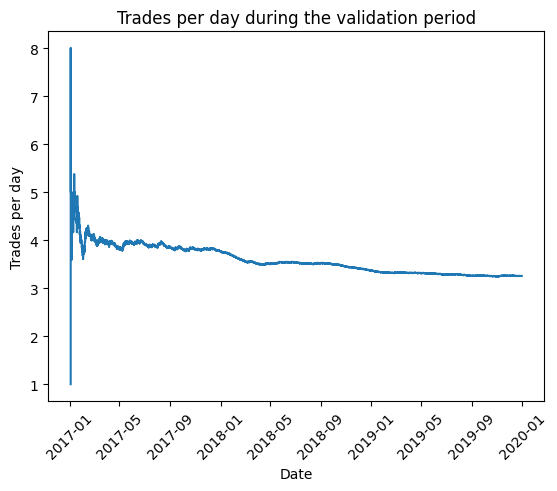

In [17]:
# Plot the trades per day during the validation period
trades_per_day_val = [x[5] for x in episodes_stats_val]
validation_dates = validation_dates[:len(trades_per_day_val)]
plt.plot(validation_dates, trades_per_day_val)
plt.xlabel('Date')
plt.ylabel('Trades per day')
plt.title('Trades per day during the validation period')
plt.xticks(rotation=45)
plt.show()

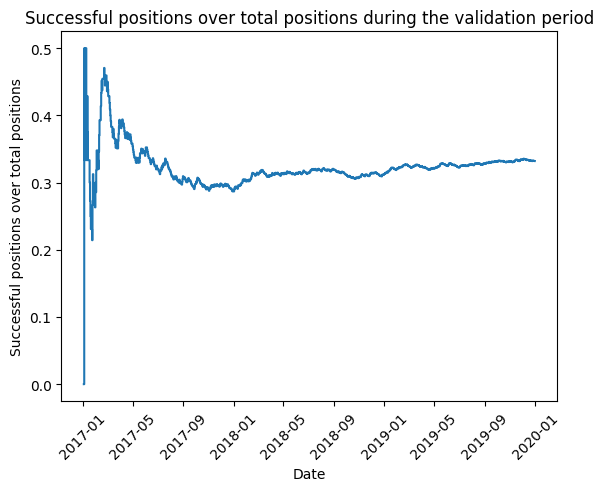

In [18]:
# Plot the successful positions over the total number of positions during the validation period
success_rate_val = [s[4] for s in episodes_stats_val]
plt.plot(validation_dates, success_rate_val)
plt.xlabel('Date')
plt.ylabel('Successful positions over total positions')
plt.title('Successful positions over total positions during the validation period')
plt.xticks(rotation=45)
plt.show()

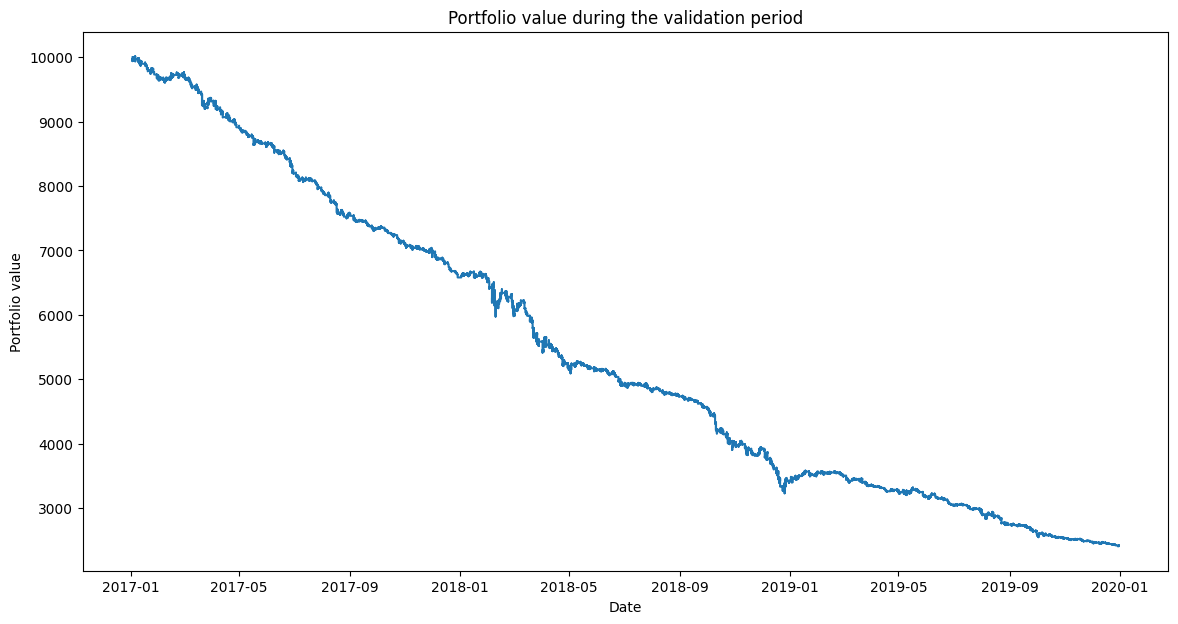

In [19]:
# Plot the portfolio value during the validation episode
# episodes_stats_val_array = np.array(episodes_stats_val)
net_worth_values_val = [x[8] for x in episodes_stats_val]
plt.figure(figsize=(14, 7))
plt.plot(validation_dates, net_worth_values_val)
plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.title('Portfolio value during the validation period')
plt.show()

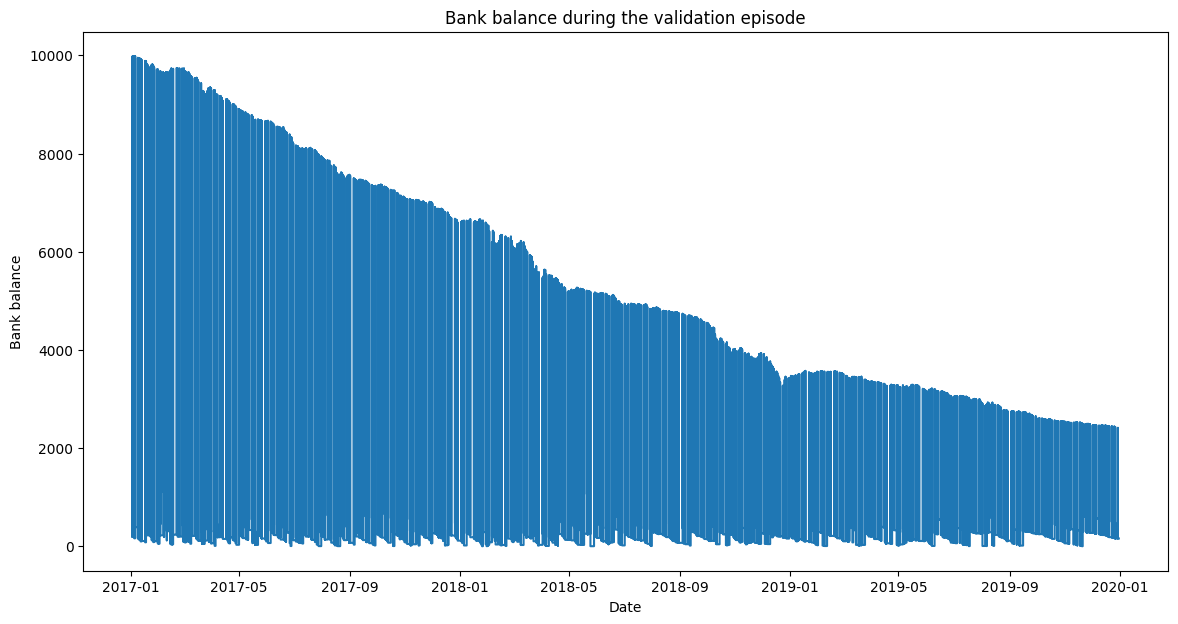

In [20]:
# Bank balance of the validation episode
bank_balance_val = [x[6] for x in episodes_stats_val]
# print(bank_balance_val)
plt.figure(figsize=(14, 7))
plt.plot(validation_dates, bank_balance_val)
plt.xlabel('Date')
plt.ylabel('Bank balance')
plt.title('Bank balance during the validation episode')
plt.show()

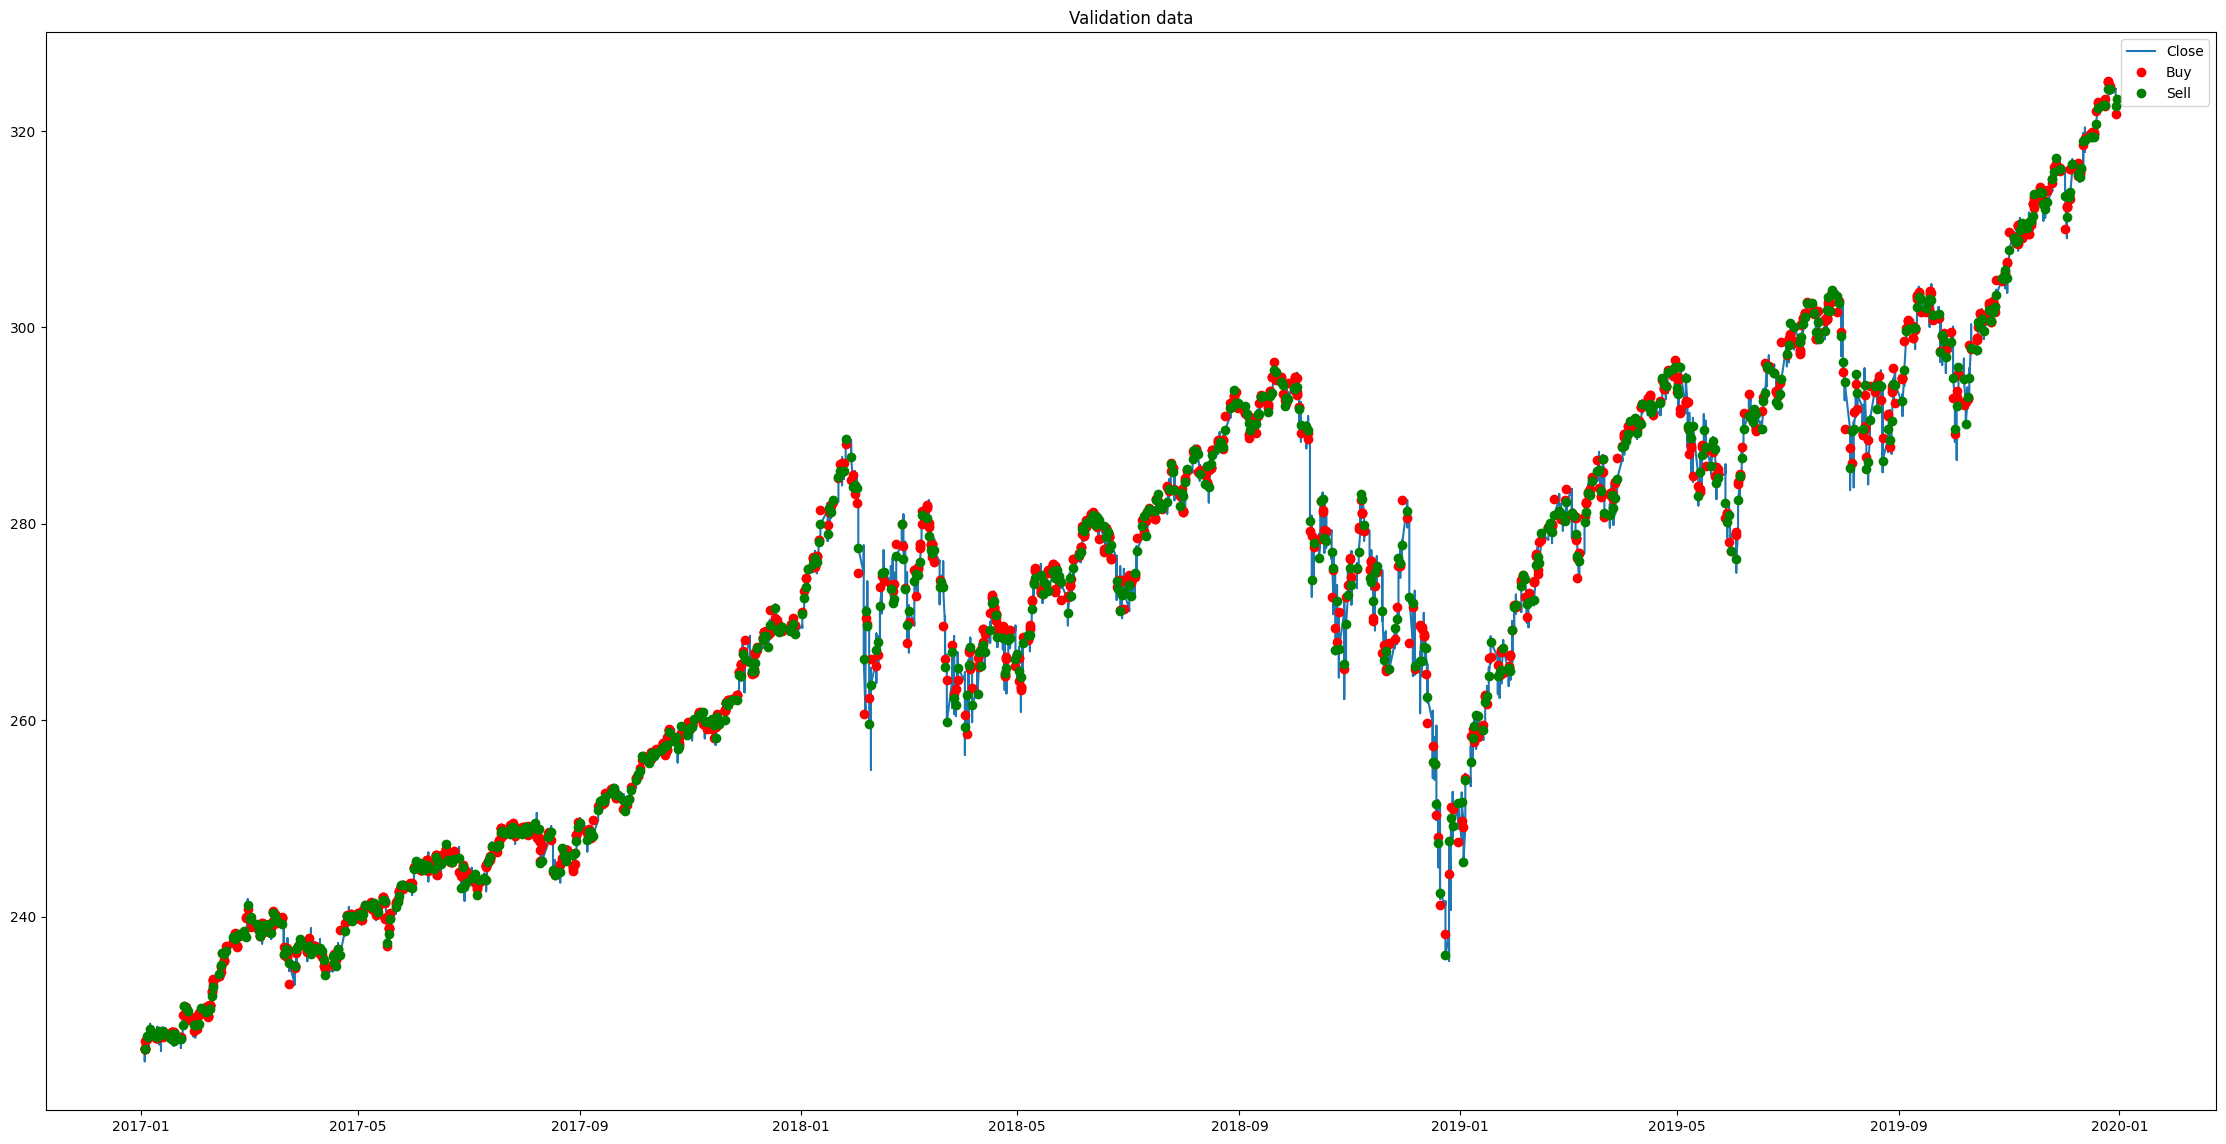

In [21]:
history_val = val_env.history
plt.figure(figsize=(28, 14))
plt.plot(validation_dates, df_val['Close'][:validation_dates.shape[0]], label='Close')
plt.plot(validation_dates, history_val['buy'][1:], 'ro', label='Buy')
plt.plot(validation_dates, history_val['sell'][1:], 'go', label='Sell')
plt.legend()
plt.title('Validation data')
plt.show()

## Conclusion and final remarks

This project had its difficulties, especially at the beginning. Our main challenge was figuring out how to use a reinforcement learning algorithm applied to the financial landscape. Looking at some examples and papers online we understood how to build the agent, the environment and how to approach this task.
In the end we learned a lot from this experience, we now understand how reinforcement learning can be applied in real-life situations. We are really happy after some struggles to see that our trading agent achieves a very high number of successful positions over the total number of positions and respects all the requirements. Of course we are disappointed because the agent can not generate actual profits and loses a lot of money but we know that this is a very tough problem and it is not easy to solve.


## Appendix: performance test (May 29th)

(387750, 6)


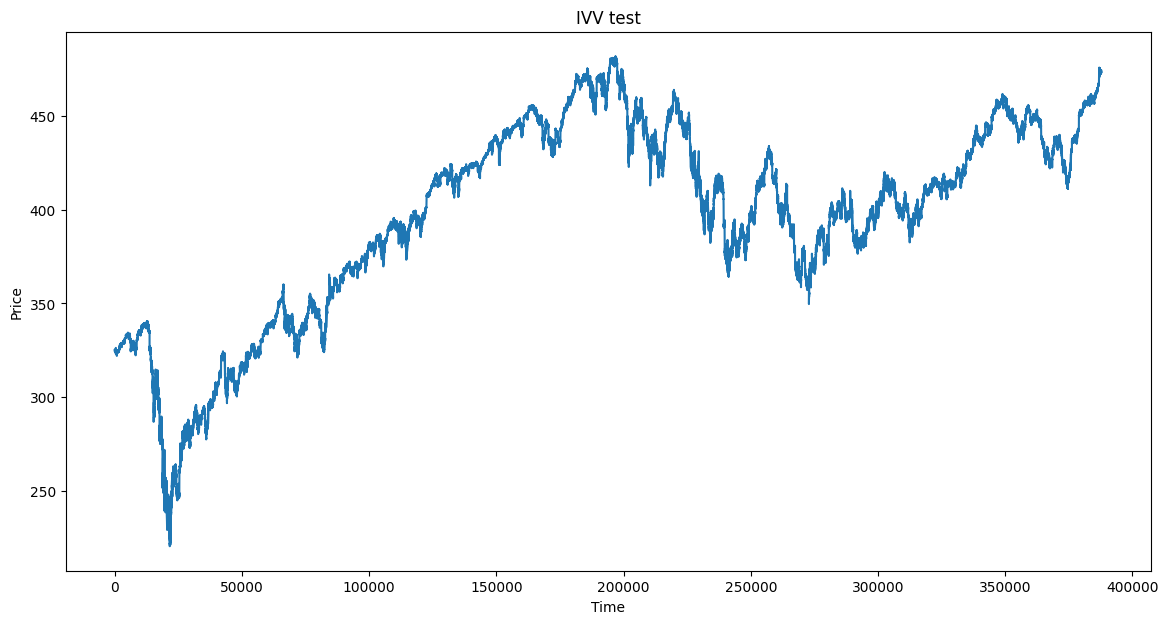

In [22]:
df_test = pd.read_csv('data/IVV_test_sample.csv')
print(df_test.shape)
plt.figure(figsize=(14, 7))
plt.plot(df_test['Close'])
plt.title('IVV test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [23]:
df_test = df_test.sort_values('DateTime')
df_test = df_test.reset_index(drop=True)
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'])

df_test_pred = pd.read_csv('lstm/test_next_close_prediction.csv')

df_test

,DateTime,Low,Volume,Open,High,Close
0,2020-01-02 14:30:00+00:00,324.9400,128113.0,324.9800,325.110,325.1093
1,2020-01-02 14:31:00+00:00,324.8703,31774.0,325.1198,325.129,324.9400
2,2020-01-02 14:32:00+00:00,324.8400,10512.0,324.9700,324.970,324.9200
3,2020-01-02 14:33:00+00:00,324.9400,19364.0,324.9400,325.240,325.1800
4,2020-01-02 14:34:00+00:00,325.1000,14302.0,325.1700,325.260,325.1000
...,...,...,...,...,...,...
387745,2023-12-15 20:55:00+00:00,474.5200,20894.0,474.6400,474.700,474.5900
387746,2023-12-15 20:56:00+00:00,474.1700,50891.0,474.5800,474.610,474.4700
387747,2023-12-15 20:57:00+00:00,474.1800,36226.0,474.5000,474.500,474.2600
387748,2023-12-15 20:58:00+00:00,474.1600,29754.0,474.2700,474.340,474.1600


In [24]:
df_test = df_test.iloc[df_test.shape[0] - df_test_pred.shape[0]:]
df_test['Prediction'] = df_test_pred.iloc[:, 0].values
df_test = df_test.dropna()
df_test = df_test.reset_index(drop=True)
df_test['Low'] = df_test['Low'].astype(np.float32)
df_test['Volume'] = df_test['Volume'].astype(np.float32)
df_test['Open'] = df_test['Open'].astype(np.float32)
df_test['High'] = df_test['High'].astype(np.float32)
df_test['Close'] = df_test['Close'].astype(np.float32)
df_test['Prediction'] = df_test['Prediction'].astype(np.float32)
df_test

,DateTime,Low,Volume,Open,High,Close,Prediction
0,2020-01-02 15:31:00+00:00,324.209991,5098.0,324.309998,324.320007,324.230011,321.200012
1,2020-01-02 15:32:00+00:00,324.179993,3875.0,324.190002,324.299988,324.299988,321.160004
2,2020-01-02 15:33:00+00:00,324.190002,9772.0,324.250000,324.350006,324.329987,321.109985
3,2020-01-02 15:34:00+00:00,324.293915,5641.0,324.320007,324.372101,324.372101,321.160004
4,2020-01-02 15:35:00+00:00,324.309998,2402.0,324.350006,324.350006,324.310699,321.160004
...,...,...,...,...,...,...,...
387543,2023-12-15 20:55:00+00:00,474.519989,20894.0,474.640015,474.700012,474.589996,427.980011
387544,2023-12-15 20:56:00+00:00,474.170013,50891.0,474.579987,474.609985,474.470001,428.079987
387545,2023-12-15 20:57:00+00:00,474.179993,36226.0,474.500000,474.500000,474.260010,428.100006
387546,2023-12-15 20:58:00+00:00,474.160004,29754.0,474.269989,474.339996,474.160004,428.089996


In [25]:
test_env = StockTradingEnv(df_test)
test_action_space = test_env.action_space
test_state_space = test_env.observation_space[1]
test_neural_net = DQN(test_state_space, test_action_space).to(device)
test_neural_net.load_state_dict(torch.load('DQN_trained_model.pth'))
test_neural_net.eval()
rewards_test, episodes_stats_test = validation_loop(test_env, test_neural_net)

  0%|          | 0/387548 [00:00<?, ?it/s]

Day: 250
Current step: 96893
Episodes reward: 425363.4953566591, reward: 4.578313253012048
Profit: -3611.5043816678863
Net Worth: 6388.495618332114
Balance: 414.2553839571142
Shares held: 16
Trades: 745
Trades per day: 2.98
Num positions: 249
Successful positions: 114
Action: 1


Day: 499
Current step: 193780
Episodes reward: 847797.3241455476, reward: 4.156626506024097
Profit: -5734.622263961458
Net Worth: 4265.377736038542
Balance: 48.69783491549515
Shares held: 9
Trades: 1520
Trades per day: 3.0460921843687374
Num positions: 498
Successful positions: 207
Action: 1


Day: 748
Current step: 290667
Episodes reward: 1261573.400391253, reward: 4.230254350736279
Profit: -7600.123433120314
Net Worth: 2399.8765668796855
Balance: 109.19657420390422
Shares held: 6
Trades: 2158
Trades per day: 2.8850267379679146
Num positions: 747
Successful positions: 316
Action: 1


----DONE----
Day: 997
Current step: 387548
Episodes reward: 1677935.1712677553, reward: -0.7572718154463391
Profit: -8196.51295

In [26]:
print(f"Total reward test: {np.mean(rewards_test)}")
print(f'Total profit test: {test_env.balance - INITIAL_ACCOUNT_BALANCE}')
ivv_return_test = 100 * (df_test['Close'].iloc[-1] / df_test['Close'].iloc[30] - 1)
print(f'IVV return test: {ivv_return_test:.2f}%')
portfolio_return_test = 100 * (test_env.net_worth / INITIAL_ACCOUNT_BALANCE - 1)
print(f'Portfolio return test: {portfolio_return_test:.2f}%')

Total reward test: 842350.5695768276
Total profit test: -8196.512956985009
IVV return test: 45.84%
Portfolio return test: -81.97%


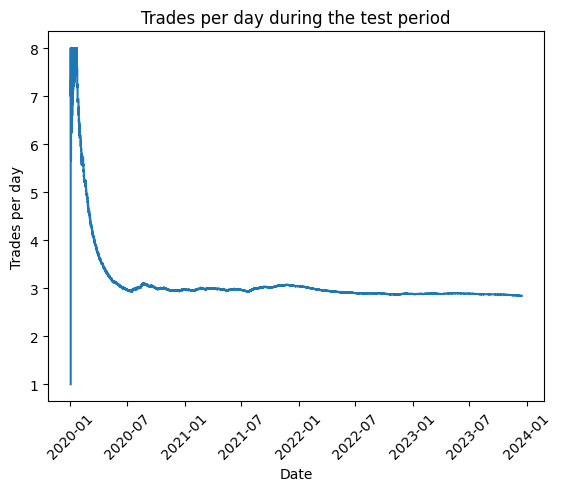

In [27]:
# Plot the trades per day during the test period
trades_per_day_test = [x[5] for x in episodes_stats_test]
test_dates = df_test['DateTime'].dt.date
test_dates = test_dates[:len(trades_per_day_test)]
plt.plot(test_dates, trades_per_day_test)
plt.xlabel('Date')
plt.ylabel('Trades per day')
plt.title('Trades per day during the test period')
plt.xticks(rotation=45)
plt.show()

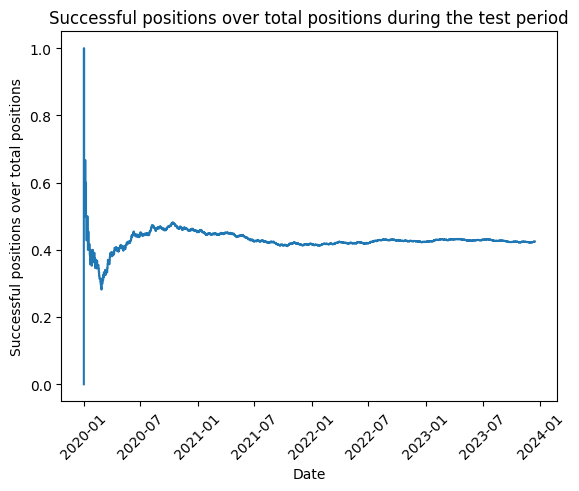

In [28]:
# Plot the successful positions over the total number of positions during the test period
success_rate_test = [s[4] for s in episodes_stats_test]
plt.plot(test_dates, success_rate_test)
plt.xlabel('Date')
plt.ylabel('Successful positions over total positions')
plt.title('Successful positions over total positions during the test period')
plt.xticks(rotation=45)
plt.show()

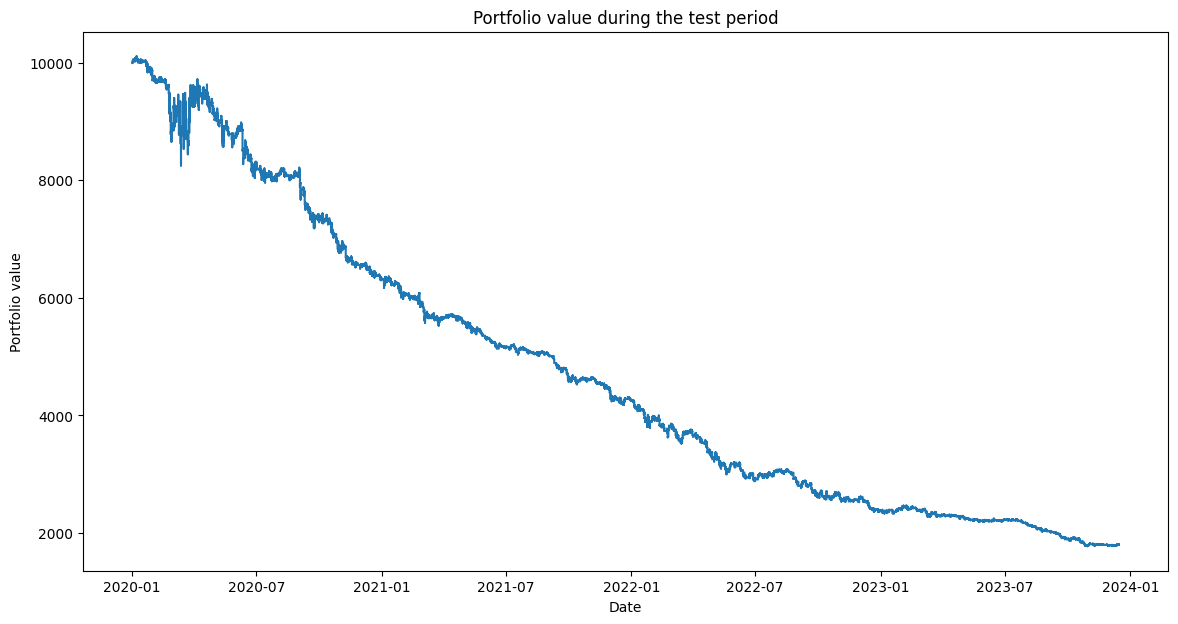

In [29]:
# Plot the portfolio value during the test episode
net_worth_values_test = [x[8] for x in episodes_stats_test]
plt.figure(figsize=(14, 7))
plt.plot(test_dates, net_worth_values_test)
plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.title('Portfolio value during the test period')
plt.show()

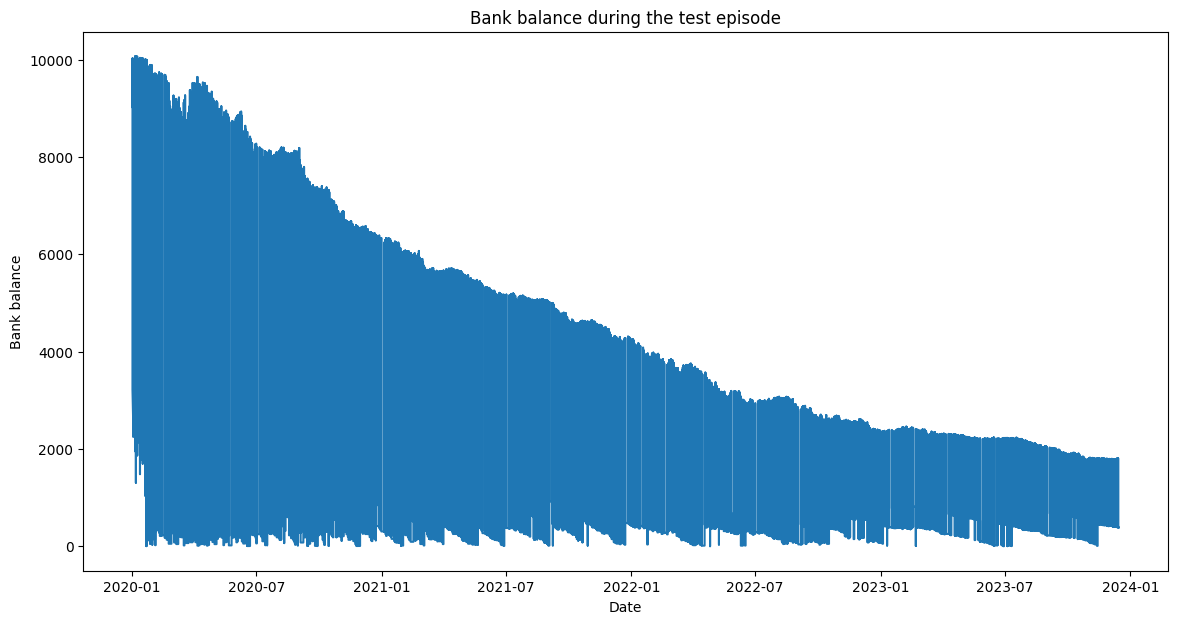

In [30]:
# Bank balance of the test episode
bank_balance_test = [x[6] for x in episodes_stats_test]
plt.figure(figsize=(14, 7))
plt.plot(test_dates, bank_balance_test)
plt.xlabel('Date')
plt.ylabel('Bank balance')
plt.title('Bank balance during the test episode')
plt.show()

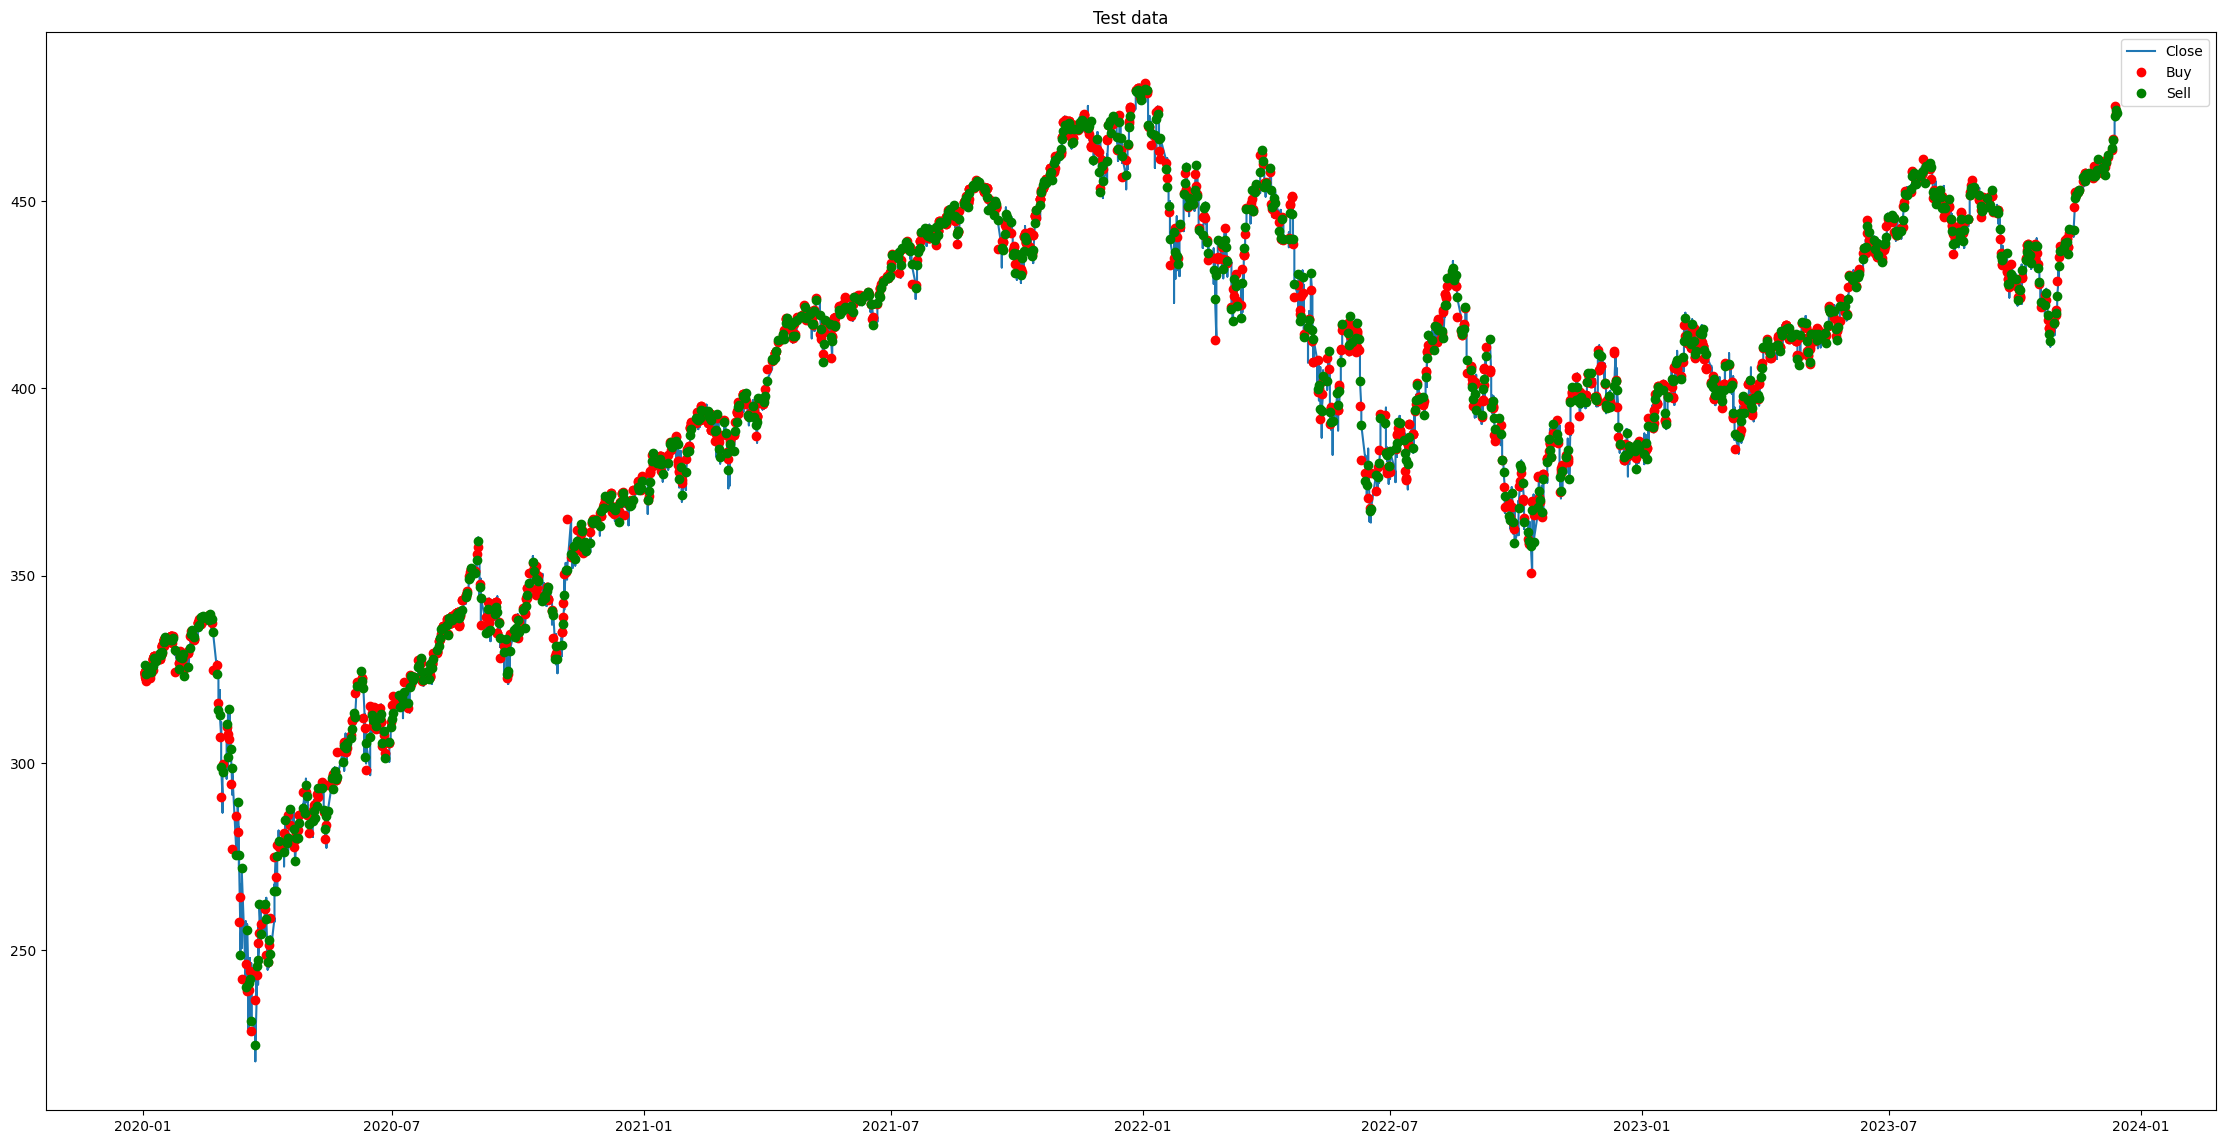

In [31]:
test_history = test_env.history
plt.figure(figsize=(28, 14))
plt.plot(test_dates, df_test['Close'][:test_dates.shape[0]], label='Close')
plt.plot(test_dates, test_history['buy'][1:], 'ro', label='Buy')
plt.plot(test_dates, test_history['sell'][1:], 'go', label='Sell')
plt.legend()
plt.title('Test data')
plt.show()